In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

import plotly.express as px
from geopy import distance

os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\EDA'

In [65]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

In [68]:
float_ids = np.unique(profile_df.float)
num_floats = len(float_ids)
print(f"Total number of floats with proper sensors: {num_floats}")

Total number of floats with proper sensors: 569


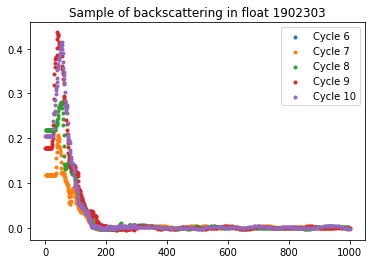

In [118]:
float = profile_df[profile_df.float == np.random.choice(float_ids)]
for i in range(5):
    plt.scatter(float[float.cycleNumber == i].PRES, float[float.cycleNumber == i].CHLA, marker=".")
plt.legend([f"Cycle {i+1}" for i in range(5, 10)])
plt.title("Sample of backscattering in float {}".format(float_ids[0]))
plt.show()

In [70]:
cycle1 = profile_df[profile_df.cycleNumber == 8]

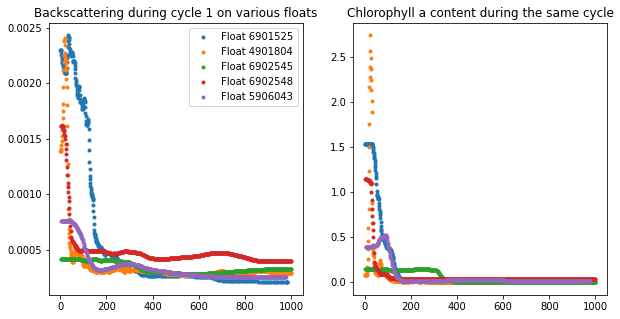

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
float_ls = np.random.choice(float_ids, size=5)
for rand_float in float_ls:
    ax[0].scatter(cycle1[cycle1.float == rand_float].PRES, cycle1[cycle1.float == rand_float].BBP700, marker=".")
    ax[1].scatter(cycle1[cycle1.float == rand_float].PRES, cycle1[cycle1.float == rand_float].CHLA, marker=".")
ax[0].legend([f"Float {f}" for f in float_ls])
ax[0].set_title("Backscattering during cycle 1 on various floats")
ax[1].set_title("Chlorophyll a content during the same cycle")
plt.show()

In [72]:
# Aggregate profile data using the mean value of chlorophyll a and bbp700 nm in the sunlit portion of the ocean
sunlit_profiles = profile_df[profile_df.PRES < 10][['float', 'cycleNumber', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber']).mean().reset_index()
df_merged = sat_df.merge(sunlit_profiles, on=['float', 'cycleNumber']).drop(['LT_SAT_SST_SD', 'LT_SAT_SST_MED'], axis=1).dropna()

### Separating merged data into mini time series periods

In [73]:
def create_period_data(merged_df):
    df = merged_df.copy()
    # create datetime column
    df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')
    # find splits between cycles in DAYS
    df['delta'] = ((df.date - df.date.shift()).dt.total_seconds() / 3600).fillna(0)
    # turn all cyclenumber 1s into 0 delta
    df.loc[df.cycleNumber == 1, 'delta'] = 0
    # start cycle over if time delta is over 15 days (360 hours)
    df.loc[(df.delta > 408) | (df.delta < 0), 'delta'] = 0
    # make a flag column for row at the end of a period
    df = df.reset_index().drop('index', axis=1)
    period_ls = list()
    period = 0
    for i, r in df.iloc[:-1].iterrows():
        if r['delta'] != 0:
            period_ls.append(period)
        else:
            r1 = df.iloc[i+1]
            if r1['delta'] != 0:
                period += 1
                period_ls.append(period)
            else:
                period_ls.append(np.nan)
    if df.iloc[-1]['delta'] != 0:
        period_ls.append(period)
    else:
        period_ls.append(np.nan)
    df['period'] = period_ls
    df = df.dropna()
    return df

df = create_period_data(df_merged)

<AxesSubplot:xlabel='delta', ylabel='Count'>

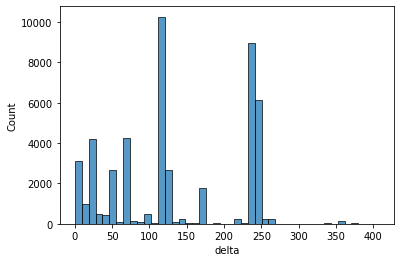

In [75]:
sns.histplot(df.delta)

In [76]:
def get_distance_series(df):
    dist_from_last = [0]
    if df.shape[0] > 1:
            for i, r in df.iloc[1:].iterrows():
                last_loc = (df.iloc[i-1].latitude, df.iloc[i-1].longitude)
                new_loc = (r.latitude, r.longitude)
                dist_from_last.append(distance.distance(last_loc, new_loc).km)
    else:
        return 0
    return dist_from_last

def gather_period_observations(df, plot=False, print_results=False):
    period_df = df.copy()
    period_df['dists_from'] = get_distance_series(period_df)
    beg_lat = period_df.iloc[0].latitude
    beg_lon = period_df.iloc[0].longitude
    info_dict = {
        'float_no': period_df.iloc[0].float,
        'period_no': period_df.iloc[0].period,
        'start_date': period_df.iloc[0].date,
        'end_date': period_df.iloc[-1].date,
        'num_cycles': period_df.shape[0],
        'avg_obsv_gap_days': period_df[1:].delta.mean() / 24,
        'total_dist_km': period_df.dists_from.sum()
    }

    if print_results:
        print(f'Float no: {period_df.iloc[0].float}\nPeriod no: {period_df.iloc[0].period}\nStart Date: {period_df.iloc[0].date}\nEnd Date: {period_df.iloc[-1].date}')
        print(f'Observations: {period_df.shape[0]}\nAvg Time Delta: {period_df[1:].delta.mean() / 24:.2f} Days\nTotal Distance Traveled: {period_df.dists_from.sum():.2f} km')
    
    if plot:
        fig = px.density_mapbox(period_df, lat='latitude', lon='longitude', z='MO_SAT_CHL', radius=8, center=dict(lat=beg_lat, lon=beg_lon), zoom=2, mapbox_style='stamen-terrain')
        fig.show()

    return info_dict

In [117]:
rand_period = np.random.choice(df.period, 5)
rand_period_df = df[df.period.isin(rand_period)].reset_index().drop('index', axis=1).reset_index()
_ = gather_period_observations(rand_period_df, plot=True)

In [78]:
periods = np.unique(df.period)
summary_data = [gather_period_observations(df[df.period == p].reset_index()) for p in periods]
summary_df = pd.DataFrame(summary_data)

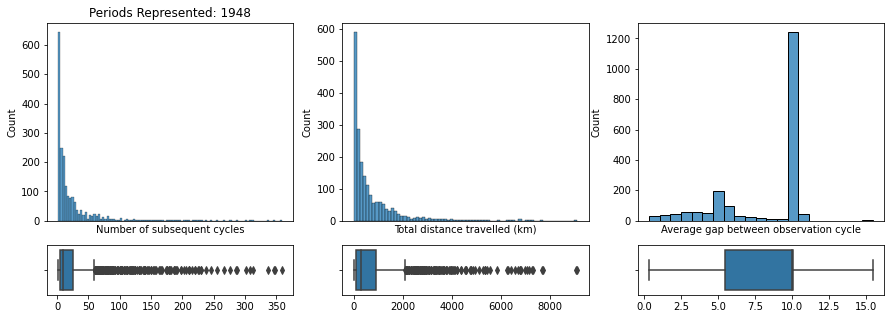

In [79]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5), gridspec_kw={"height_ratios": (.8, .2)})

ax[0, 0].set_title(f'Periods Represented: {summary_df.shape[0]}')

sns.histplot(data=summary_df, x='num_cycles', ax=ax[0, 0])
sns.boxplot(data=summary_df, x='num_cycles', ax=ax[1, 0])
ax[1, 0].set_xlabel('')
ax[0, 0].tick_params(bottom=False, labelbottom=False)
ax[0, 0].set_xlabel('Number of subsequent cycles')

sns.histplot(data=summary_df, x='total_dist_km', ax=ax[0, 1])
sns.boxplot(data=summary_df, x='total_dist_km', ax=ax[1, 1])
ax[1, 1].set_xlabel('')
ax[0, 1].tick_params(bottom=False, labelbottom=False)
ax[0, 1].set_xlabel('Total distance travelled (km)')

sns.histplot(data=summary_df, x='avg_obsv_gap_days', ax=ax[0, 2])
sns.boxplot(data=summary_df, x='avg_obsv_gap_days', ax=ax[1, 2])
ax[1, 2].set_xlabel('')
ax[0, 2].tick_params(bottom=False, labelbottom=False)
ax[0, 2].set_xlabel('Average gap between observation cycle')

plt.show()

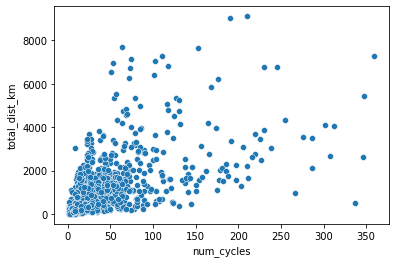

In [87]:
sns.scatterplot(data=summary_df, x='num_cycles', y='total_dist_km')
high_len_periods = summary_df[summary_df.total_dist_km > 4000].period_no

**Correlation between period CHLA distributions**

In [81]:
df_period_merge = profile_df.merge(df[['float', 'cycleNumber', 'period', 'latitude', 'longitude', 'MO_SAT_CHL']], on=['float', 'cycleNumber'])

Float no: 2902748
Period no: 244.0
Start Date: 2019-03-31 13:53:53
End Date: 2021-05-11 23:59:22
Observations: 230
Avg Time Delta: 3.37 Days
Total Distance Traveled: 6758.28 km


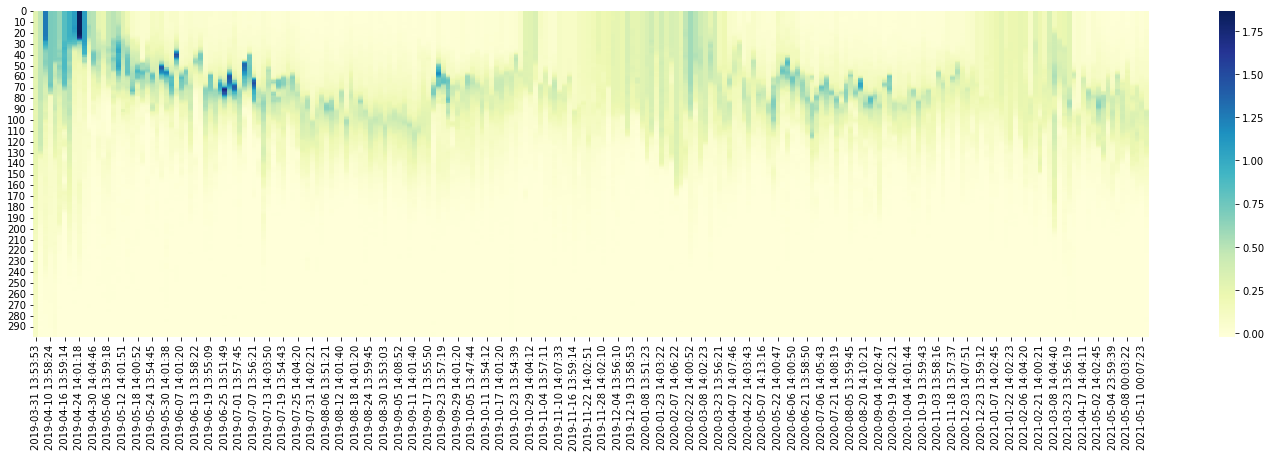

0.3056599522640657

In [116]:
long_period = np.random.choice(high_len_periods)
high_len_df = df_period_merge[df_period_merge.period == long_period]

heatmap = {}
for date in np.unique(high_len_df.date):
    heatmap[date] = high_len_df[high_len_df.date == date].sort_values('PRES').CHLA.to_numpy()[:300]
df_heat = pd.DataFrame(heatmap)

long_period_df = df[df.period == long_period].reset_index().drop('index', axis=1).reset_index()
_ = gather_period_observations(long_period_df, plot=True, print_results=True)
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.heatmap(df_heat, cmap="YlGnBu", ax=ax)
plt.show()

np.triu(df_heat.corr().to_numpy(), k=1).mean()


### RidgeReg and Corrlelation on Merged Data

In [109]:
df.corr(method="spearman").style.background_gradient()

,float,cycleNumber,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP,LT_SAT_CHL_SD,LT_SAT_CHL_MED,LT_SAT_BBP_SD,LT_SAT_BBP_MED,CHLA,BBP700,delta,period
float,1.000000,-0.022889,0.283523,-0.133037,0.387262,-0.201853,0.146172,0.010184,0.157789,0.156622,0.009830,0.033728,0.063744,0.041304,-0.273490,0.999996
cycleNumber,-0.022889,1.000000,0.031182,0.071679,-0.013561,0.049737,-0.049370,-0.058731,-0.063233,-0.052914,-0.020424,-0.057188,-0.062060,-0.076029,-0.030380,-0.021221
latitude,0.283523,0.031182,1.000000,-0.124684,0.330924,0.205679,0.171777,-0.296693,0.222795,0.208036,-0.111763,-0.351423,-0.164312,-0.140565,-0.314773,0.283514
longitude,-0.133037,0.071679,-0.124684,1.000000,0.112675,0.004823,0.047980,0.004759,0.079862,0.037156,0.074329,-0.041536,0.072123,0.042978,-0.077576,-0.132986
elevation,0.387262,-0.013561,0.330924,0.112675,1.000000,-0.233183,0.353817,0.024754,0.412881,0.376611,0.212501,0.036361,0.196679,0.176191,-0.169487,0.387250
MO_SAT_SST,-0.201853,0.049737,0.205679,0.004823,-0.233183,1.000000,-0.587878,-0.441552,-0.570437,-0.601446,-0.736313,-0.720455,-0.662072,-0.586250,0.002512,-0.201821
MO_SAT_CHL,0.146172,-0.049370,0.171777,0.047980,0.353817,-0.587878,1.000000,0.434213,0.804691,0.865171,0.726767,0.522985,0.767782,0.726978,-0.061097,0.146067
MO_SAT_BBP,0.010184,-0.058731,-0.296693,0.004759,0.024754,-0.441552,0.434213,1.000000,0.314424,0.386527,0.500428,0.637477,0.561635,0.663707,0.075338,0.010125
LT_SAT_CHL_SD,0.157789,-0.063233,0.222795,0.079862,0.412881,-0.570437,0.804691,0.314424,1.000000,0.918246,0.783237,0.491140,0.621096,0.601698,-0.072405,0.157630
LT_SAT_CHL_MED,0.156622,-0.052914,0.208036,0.037156,0.376611,-0.601446,0.865171,0.386527,0.918246,1.000000,0.830546,0.608107,0.679076,0.651129,-0.071303,0.156495


In [ ]:
Xc = df[["latitude", "MO_SAT_CHL", "LT_SAT_CHL_MED"]]
yc = df["CHLA"]
Xb = df[["latitude", "MO_SAT_BBP", "LT_SAT_BBP_MED"]]
yb = df["BBP700"]

rclf_c = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, scoring='neg_mean_squared_error').fit(Xc, yc)
print("Initial score for ridgereg [CHLA]: {}".format(rclf_c.score(Xc, yc)))

rclf_b = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, scoring='neg_mean_squared_error').fit(Xb, yb)
print("Initial score for ridgereg [BBP700]: {}".format(rclf_b.score(Xb, yb)))

Initial score for ridgereg [CHLA]: 0.36016952453696793
Initial score for ridgereg [BBP700]: 0.004898620373892992


**Above** - Linear models won't work well for our data

### Questions / Comments on Neural Net Paper

1. How are the input values giving four "potential density values along the vertical profile" derived? (aren't those theoretically very similar to the output values we are trying to achieve? Are they using some aggregation of past float values based on time / location?)

2. Clarification on the use of Z_norm values and their relationship to attenuation coefficients at very specific wavelengths. Further clarification on the lack of similarity between Z_norm calculation between stratified and mixed water columns. (How are they finding this "statistical optimality")

3. What pieces of the dataset we have in hand are similar to the data they calculated / used (what do we have and what else do we need to calculate to repeat / extend their work)

In [23]:
df['date_doy'] = df['date'].apply(lambda x: pd.Period(x, freq='D').day_of_year)
df['date_doy_rad'] = df['date_doy'] * (np.pi /182.625)
score = list()

In [27]:
Xc_boost = df[["latitude", "longitude", "date_doy_rad", "MO_SAT_CHL", "MO_SAT_BBP", "MO_SAT_SST"]]
# Xc_boost = df[["latitude", "MO_SAT_CHL", "LT_SAT_CHL_MED", "date_doy_rad"]]
# Xc_boost = df[["latitude", "MO_SAT_CHL", "date_doy_rad", "MO_SAT_SST"]]
yc_boost = df["CHLA"]

X_tr, X_te, y_tr, y_te = train_test_split(Xc_boost, yc_boost, test_size=0.15, random_state=23)

reg = GradientBoostingRegressor(loss="squared_error", random_state=23)
hist = reg.fit(X_tr, y_tr)
score1 = reg.score(X_te, y_te)

score.append(score1)
print(score)

[0.5860343287594103, 0.5871506921257765]


In [28]:
preds = reg.predict(X_te)
mae = mean_absolute_error(y_te, preds)
print(f"Mean absolute error: {mae}")
print(f"Mean pred value: {np.mean(preds)}")
print(f"Std. of preds: {np.std(preds)}")
print(f"Mean label value: {np.mean(y_te)}")
print(f"Std. of labels: {np.std(y_te)}")
print(f"Range of labels: {np.min(y_te)}, {np.max(y_te)}")

Mean absolute error: 0.0920466454568321
Mean pred value: 0.28271655683345065
Std. of preds: 0.2139797570054061
Mean label value: 0.27842482497869875
Std. of labels: 0.26812646490390013
Range of labels: -0.02817023744102982, 4.841698022863519


### Check average distance between two date recordings

In [26]:
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d %H:%M:%S')

In [34]:
deltas = list()
for f in np.unique(df.float):
    float_df = df[df.float == f].sort_values(by='date', ascending=True)
    float_df['delta'] = (float_df['date'] - float_df['date'].shift()).fillna(pd.Timedelta('0 days'))
    float_df['delta_hrs'] = float_df['delta'].apply(lambda x: x / np.timedelta64(1, 'D')).astype('float')
    deltas += list(float_df['delta_hrs'])

In [39]:
deltas = np.array(deltas)
deltas_filt = deltas[(deltas < 80) & (deltas > 0)]

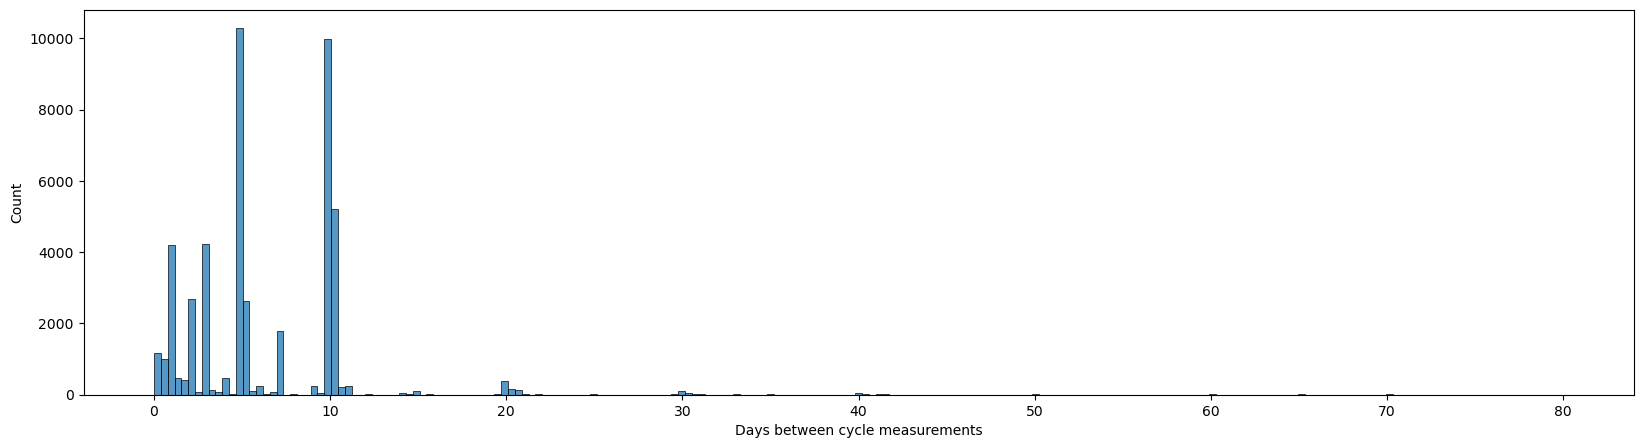

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.histplot(x=deltas_filt, ax=ax)
ax.set_xlabel('Days between cycle measurements')
plt.show()

In [74]:
est = KMeans(n_clusters=6)
groups = est.fit_predict(df[['BBP700', "CHLA"]])

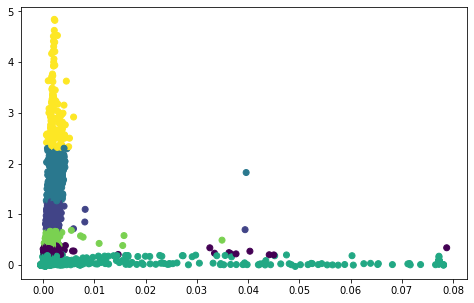

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(df.BBP700.to_list(), df.CHLA.to_list(), c=groups)
plt.show()

In [45]:
depth_profiles = profile_df[['float', 'cycleNumber', 'bins', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

In [53]:
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']
df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()

### Data Merging and Binning

In [10]:
PROFILE_DATA_PATH = "../data/profileData.csv"
SAT_DATA_PATH = "../data/satData.csv"
drop_cols = ['LT_SAT_SST_SD', 'LT_SAT_SST_MED', 'LT_SAT_CHL_SD', 'LT_SAT_CHL_MED', 'LT_SAT_BBP_SD', 'LT_SAT_BBP_MED']

profile_df = pd.read_csv(PROFILE_DATA_PATH)
sat_df = pd.read_csv(SAT_DATA_PATH)

out = pd.cut(profile_df.PRES, bins=50, labels=[i for i in range(50)])
profile_df['depth_bin'] = out

depth_profiles = profile_df[['float', 'cycleNumber', 'depth_bin', 'CHLA', 'BBP700']] \
    .groupby(['float', 'cycleNumber', 'depth_bin']).mean().reset_index().dropna()

df_depth = depth_profiles.merge(sat_df, on=['float', 'cycleNumber']).drop(drop_cols, axis=1).dropna()
df_depth['date'] = pd.to_datetime(df_depth.date, format='%Y-%m-%d %H:%M:%S')

### Check out distributions found by Gabby

In [2]:
df_dist = pd.read_csv('../data/cluster_chla_distribution.csv')

<AxesSubplot:xlabel='PRES', ylabel='CHLA'>

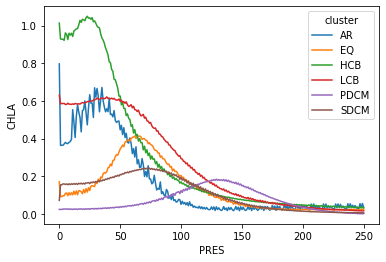

In [4]:
sns.lineplot(data=df_dist, x='PRES', y='CHLA', hue='cluster')

In [11]:
out = pd.cut(df_dist.PRES, bins=25, labels=[i for i in range(25)])
df_dist['depth_bin'] = out


df_dist_binned = df_dist[['cluster', 'depth_bin', 'CHLA']] \
    .groupby(['cluster', 'depth_bin']).mean().reset_index().dropna()

<AxesSubplot:xlabel='depth_bin', ylabel='CHLA'>

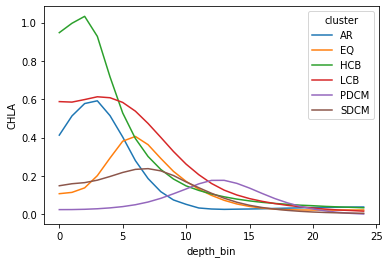

In [12]:
sns.lineplot(data=df_dist_binned, x='depth_bin', y='CHLA', hue='cluster')

In [14]:
from scipy.optimize import curve_fit
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c

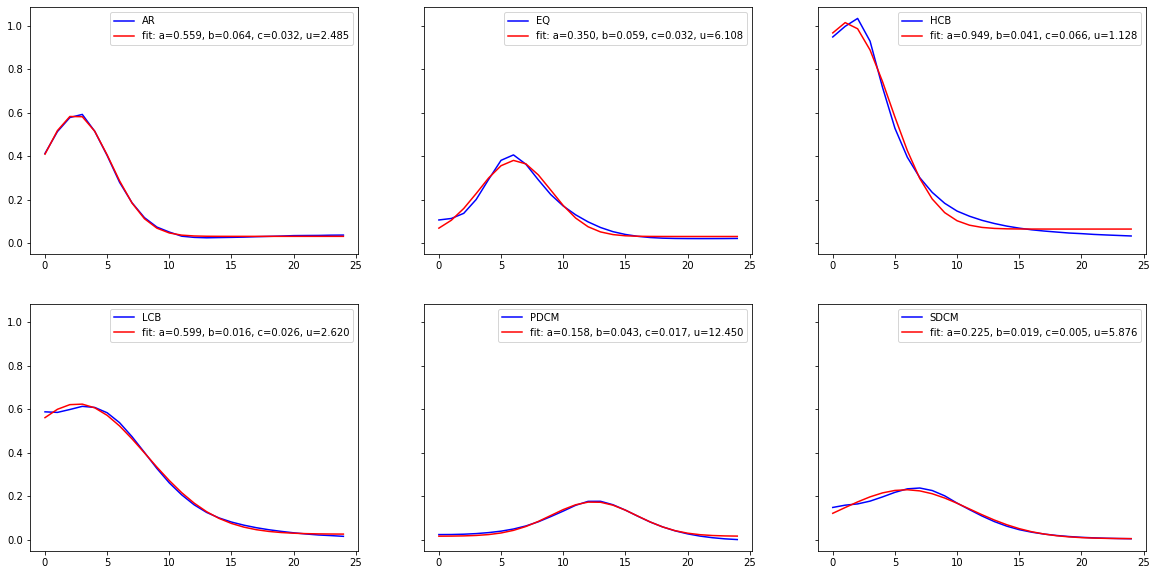

In [24]:
xdata = np.linspace(0, 24, 25)
bounds = ([0, 0, 0, 0], [10.0, 5.0, 0.1, 20])
raw_dists = list()
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for i, c in enumerate(np.unique(df_dist_binned.cluster)):
    ydata = df_dist_binned[df_dist_binned.cluster == c]['CHLA'].to_numpy()
    raw_dists.append(ydata)
    ax[i // 3, i % 3].plot(xdata, ydata, 'b-', label=c)

    popt, pcov = curve_fit(func, xdata, ydata, bounds=bounds)
    ax[i // 3, i % 3].plot(xdata, func(xdata, *popt), 'r-',
            label='fit: a=%5.3f, b=%5.3f, c=%5.3f, u=%5.3f' % tuple(popt))

    ax[i // 3, i % 3].legend()

In [25]:
km = sklearn.cluster.KMeans(n_clusters=6)
km.fit(np.array(raw_dists))

KMeans(n_clusters=6)

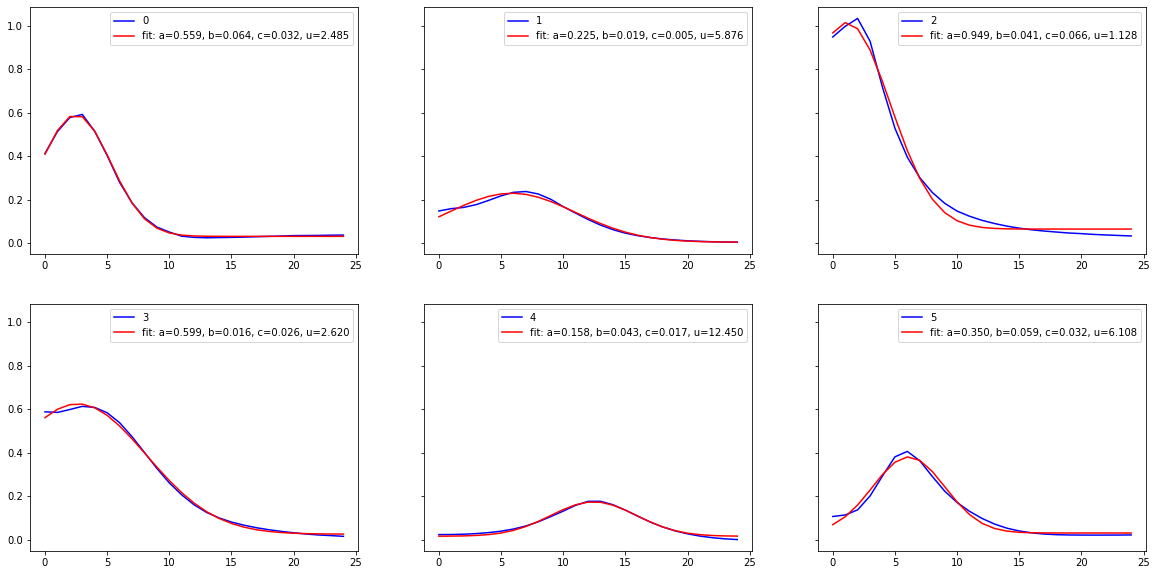

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
for i, c in enumerate(km.cluster_centers_):
    ydata = c
    ax[i // 3, i % 3].plot(xdata, ydata, 'b-', label=i)

    popt, pcov = curve_fit(func, xdata, ydata, bounds=bounds)
    ax[i // 3, i % 3].plot(xdata, func(xdata, *popt), 'r-',
            label='fit: a=%5.3f, b=%5.3f, c=%5.3f, u=%5.3f' % tuple(popt))

    ax[i // 3, i % 3].legend()

### Try to make normalized data

In [111]:
def mix_data(row, norm_depths):
    norm_values = list()
    for depth in norm_depths:
        mid = np.floor(depth).astype('int64')
        perc_up = 1 - (depth - mid)
        perc_down = 1 - perc_up
        chla = (row.iloc[mid-1]*perc_down)+(row.iloc[mid]*perc_up)
        norm_values.append(chla)
    return norm_values

In [112]:
# read in necessary data
df_pivoted = pd.read_csv('../data/pivoted_imp_data.csv')
df_clusters = pd.read_csv('../data/cluster_classification_assignment.csv', low_memory=False)
df_train_xgb = pd.read_csv('../data/xgb_train_preds.csv')
df_test_xgb = pd.read_csv('../data/xgb_test_preds.csv')

def build_normalized_data(df_pivoted, df_clusters, df_train_xgb, df_test_xgb, save=False, return_df=True):
    # add train test tag for splitting later
    df_train_xgb['train'] = 1
    df_test_xgb['train'] = 0

    # get information on max depth and train test split using Josie's data
    df_norm_depth = pd.concat([df_train_xgb, df_test_xgb]).groupby(['float', 'cycle']).max().reset_index().rename(columns={'cycle': 'cycleNumber', 'PRES': 'max_depth'})[['float', 'cycleNumber', 'max_depth', 'train']]
    # merge with pivoted data I created
    df_norm_piv = df_pivoted.merge(df_norm_depth, on=['float', 'cycleNumber'])
    # add clusters from Gabby's data
    df_norm_piv = df_norm_piv.merge(df_clusters[['float', 'cycleNumber', 'cluster']],
                                    on=['float', 'cycleNumber']).drop_duplicates()
    print(f'Rows lost on specific train test split merger w max normalized depth\nand merger with cluster data: {df_pivoted.shape[0] - df_norm_piv.shape[0]}')

    # make an integer value representing the max bin to use in normalized data
    df_norm_piv['max_bin'] = (np.floor(df_norm_piv.max_depth / 10) + 1).astype('int64')

    norm_vals = {
        'norm_1': [],
        'norm_2': [],
        'norm_3': [],
        'norm_4': []
    }
    # iterate through dataframe and find the CHLA values at normalized depths
    for i, r in df_norm_piv.iterrows():
        depths = r[r.index.str.contains('depth_bin')].iloc[:r.max_bin + 1]
        norm_depths = np.linspace(0, r.max_bin, 4).round(1).astype('int64')
        vals = mix_data(depths, norm_depths)
        norm_vals['norm_1'].append(vals[0])
        norm_vals['norm_2'].append(vals[1])
        norm_vals['norm_3'].append(vals[2])
        norm_vals['norm_4'].append(vals[3])

    # add the depths to the train test set
    df_norm_piv['norm_1'] = norm_vals['norm_1']
    df_norm_piv['norm_2'] = norm_vals['norm_2']
    df_norm_piv['norm_3'] = norm_vals['norm_3']
    df_norm_piv['norm_4'] = norm_vals['norm_4']
    
    # factorize clusters for stratification
    cluster_nums, cluster_indeces = pd.factorize(df_norm_piv.cluster)
    df_norm_piv['cluster_val'] = cluster_nums
    if save == True:
        df_norm_piv.to_csv('../data/final_norm_set.csv', index=False)
    if return_df == True:
        return df_norm_piv
df_norm_piv = build_normalized_data(df_pivoted, df_clusters, df_train_xgb, df_test_xgb)


Rows lost on specific train test split merger w max normalized depth
and merger with cluster data: 2374


In [109]:
cluster_indeces = ['HCB', 'PDCM', 'EQ', 'LCB', 'AR', 'SDCM']

In [113]:
# get features
full_train = df_norm_piv[df_norm_piv.train == 1]
full_test = df_norm_piv[df_norm_piv.train == 0]

In [18]:
smote_test_x = full_train[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month'] + ['norm_' + str(i) for i in range(1, 5)]]
smote_test_y =  full_train['cluster_val']

In [47]:
print(smote_test_y.value_counts().median())
print(smote_test_y.value_counts())

5258.5
3    9856
5    8539
2    5616
1    4901
0    4455
4     728
Name: cluster_val, dtype: int64


In [120]:
strategy = {
    0: 15000,
    1: 5259,
    2: 5616,
    3: 9856,
    4: 5259,
    5: 8539
}
sm = SMOTE()
test_output_x, test_output_y = sm.fit_resample(smote_test_x, smote_test_y)

In [121]:
X_train = test_output_x[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# X_train = full_train[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test = full_test[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# get labels
label_bins = [1, 2, 3, 4]
Y_train = test_output_x[['norm_' + str(i) for i in label_bins]]
# Y_train = full_train[['norm_' + str(i) for i in label_bins]]
Y_test = full_test[['norm_' + str(i) for i in label_bins]]

input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

nn_model = Sequential()

nn_model.add(Dense(108, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(28, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

# fit the model
nn_history = nn_model.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=1)

preds = nn_model.predict(X_test)
actuals = Y_test.to_numpy()
mean_squared_error(actuals, preds)

Epoch 1/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.1227
Epoch 2/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.1062
Epoch 3/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.1010
Epoch 4/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.1023
Epoch 5/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0997
Epoch 6/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0955
Epoch 7/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0976
Epoch 8/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0940
Epoch 9/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0944
Epoch 10/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0944
Epoch 11/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0934
Epoch 12/15
1848/1848 [==============================] - 7s 4ms/step - loss: 0.0918
E

0.09391914124920864

In [124]:
full_test_w_preds = full_test.reset_index().drop('index', axis=1).join(pd.DataFrame(preds, columns=['pred_1', 'pred_2', 'pred_3', 'pred_4']))

**Median SMOTE**

In [99]:
for i in range(6):
    cluster_preds = full_test_w_preds[full_test_w_preds.cluster_val == i]
    mse_i = mean_squared_error(cluster_preds[['norm_' + str(i) for i in range(1, 5)]], cluster_preds[['pred_' + str(i) for i in range(1, 5)]])
    print(f'MSE for Cluster {cluster_indeces[i]} ({i}) w/ {full_test_w_preds.cluster_val.value_counts().loc[i]} examples: {mse_i}')

MSE for Cluster HCB (0) w/ 1048 examples: 0.38347632545461907
MSE for Cluster PDCM (1) w/ 1229 examples: 0.00403765755560043
MSE for Cluster EQ (2) w/ 1405 examples: 0.014720194006573602
MSE for Cluster LCB (3) w/ 2399 examples: 0.11540002384995712
MSE for Cluster AR (4) w/ 173 examples: 0.050351175261569535
MSE for Cluster SDCM (5) w/ 1989 examples: 0.03443977591273984


**Raw Test Data**

In [115]:
for i in range(6):
    cluster_preds = full_test_w_preds[full_test_w_preds.cluster_val == i]
    mse_i = mean_squared_error(cluster_preds[['norm_' + str(i) for i in range(1, 5)]], cluster_preds[['pred_' + str(i) for i in range(1, 5)]])
    print(f'MSE for Cluster {cluster_indeces[i]} ({i}) w/ {full_test_w_preds.cluster_val.value_counts().loc[i]} examples: {mse_i}')

MSE for Cluster HCB (0) w/ 1048 examples: 0.38256454820776914
MSE for Cluster PDCM (1) w/ 1229 examples: 0.003470060490758058
MSE for Cluster EQ (2) w/ 1405 examples: 0.01471759671963327
MSE for Cluster LCB (3) w/ 2399 examples: 0.11350015053171074
MSE for Cluster AR (4) w/ 173 examples: 0.04982742494629727
MSE for Cluster SDCM (5) w/ 1989 examples: 0.03726312147355662


**Max Smote for HCB / median for the rest**

In [119]:
for i in range(6):
    cluster_preds = full_test_w_preds[full_test_w_preds.cluster_val == i]
    mse_i = mean_squared_error(cluster_preds[['norm_' + str(i) for i in range(1, 5)]], cluster_preds[['pred_' + str(i) for i in range(1, 5)]])
    print(f'MSE for Cluster {cluster_indeces[i]} ({i}) w/ {full_test_w_preds.cluster_val.value_counts().loc[i]} examples: {mse_i}')

MSE for Cluster HCB (0) w/ 1048 examples: 0.3795936892489867
MSE for Cluster PDCM (1) w/ 1229 examples: 0.0032965413856004687
MSE for Cluster EQ (2) w/ 1405 examples: 0.01447487403838776
MSE for Cluster LCB (3) w/ 2399 examples: 0.11471577964104641
MSE for Cluster AR (4) w/ 173 examples: 0.05019114838522483
MSE for Cluster SDCM (5) w/ 1989 examples: 0.03319487133630501


**1.6x representation of HCB/ mediand for rest**

In [125]:
for i in range(6):
    cluster_preds = full_test_w_preds[full_test_w_preds.cluster_val == i]
    mse_i = mean_squared_error(cluster_preds[['norm_' + str(i) for i in range(1, 5)]], cluster_preds[['pred_' + str(i) for i in range(1, 5)]])
    print(f'MSE for Cluster {cluster_indeces[i]} ({i}) w/ {full_test_w_preds.cluster_val.value_counts().loc[i]} examples: {mse_i}')

MSE for Cluster HCB (0) w/ 1048 examples: 0.3695978810120933
MSE for Cluster PDCM (1) w/ 1229 examples: 0.004230976757198532
MSE for Cluster EQ (2) w/ 1405 examples: 0.01454600136330836
MSE for Cluster LCB (3) w/ 2399 examples: 0.11591985005497446
MSE for Cluster AR (4) w/ 173 examples: 0.04992797422455164
MSE for Cluster SDCM (5) w/ 1989 examples: 0.03744124677917316


In [55]:
def func(x, a, b, c, u):
    return a * np.exp(-b * (x - u)**2) + c

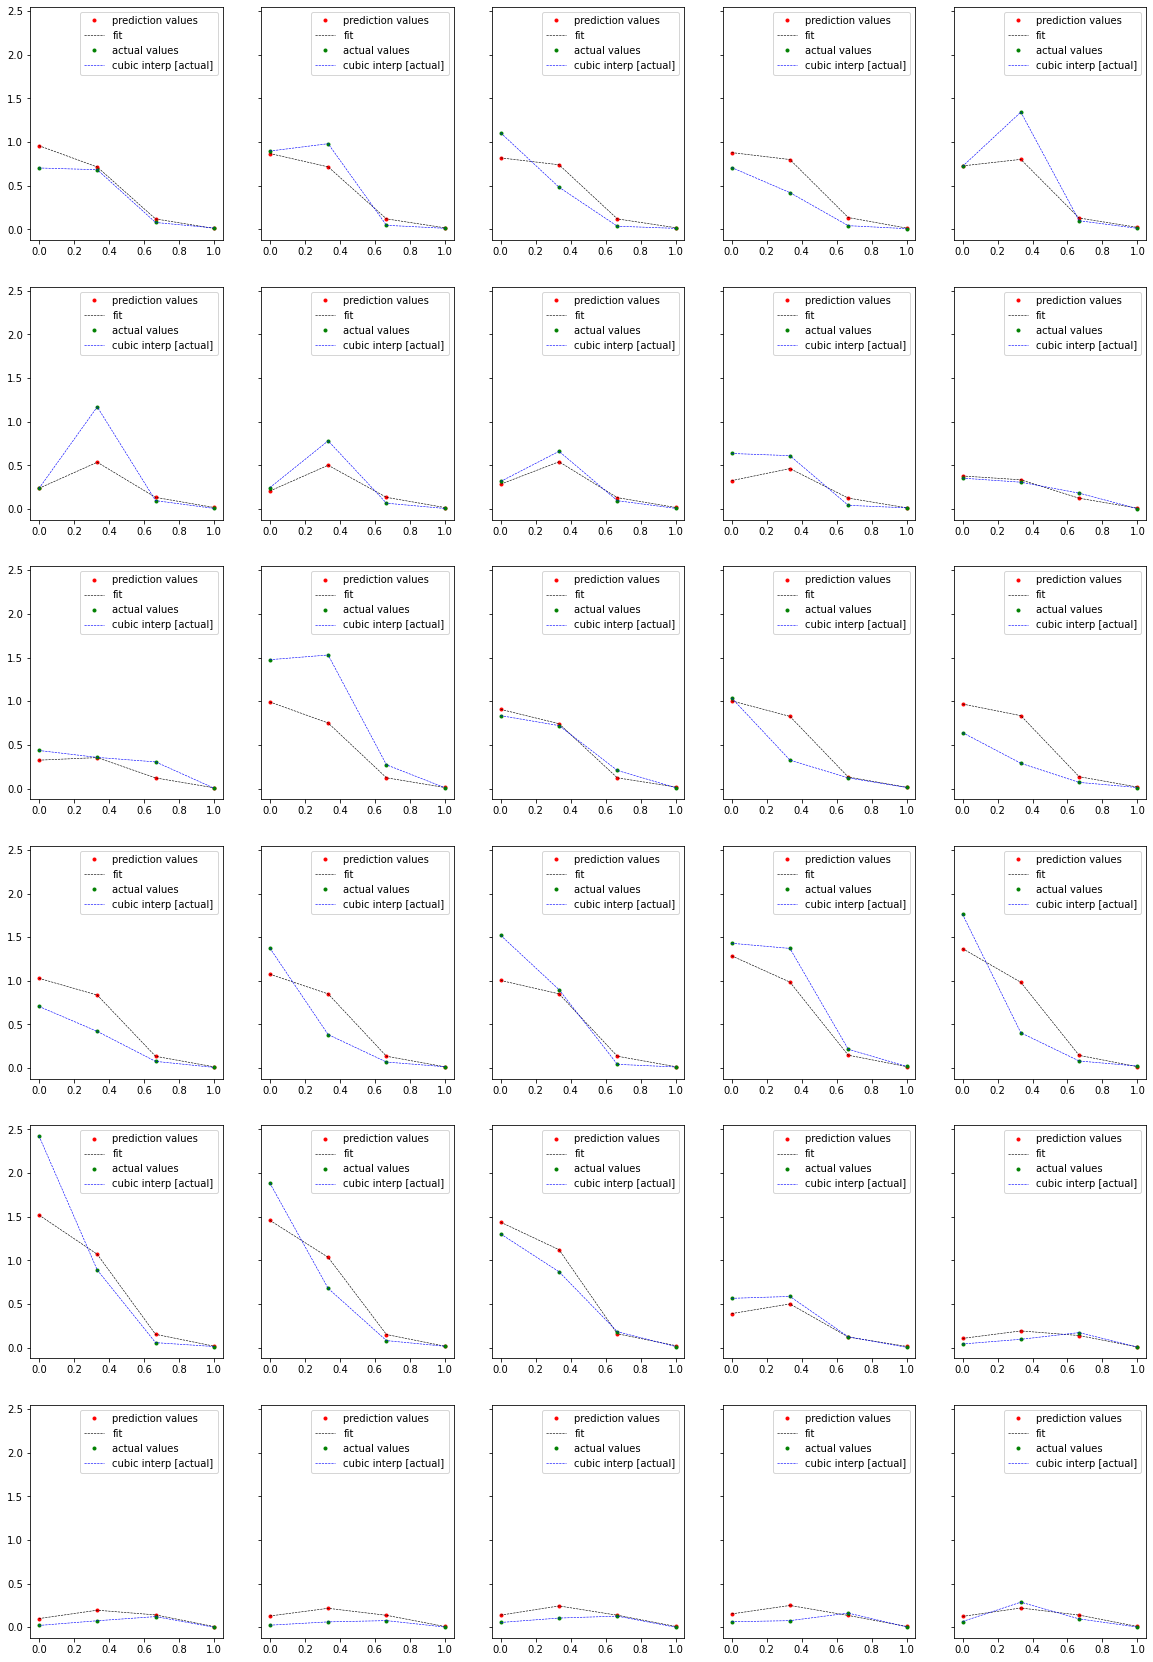

In [76]:
fig, ax = plt.subplots(6, 5, figsize=(20, 30), sharey=True)
xdata = np.linspace(0, 1, 4)
xnew = np.linspace(0, 1, 25)

optimal_params = list()
# bounds = ([0, 0.00032, 0, -0.2], [10, 0.008, 0.25, 0.64])
bounds = ([0, 0.00032, -3, -1], [10.0, 0.2, 2, 1])

for i, p in enumerate(preds[:30, :]):
    fp = interp1d(xdata, p, kind='slinear')
    pinter = fp(xnew)
    fa = interp1d(xdata, actuals[i], kind='slinear')
    ainter = fa(xnew)
    try:
        popt, pcov = curve_fit(func, xnew, pinter, bounds=bounds)
    except RuntimeError:
        continue
    if i < 30:
        arow = i // 5
        acol = i % 5
        ax[arow, acol].plot(xdata, p, 'r.', label='prediction values')
        ax[arow, acol].plot(xnew, pinter, 'k--', linewidth=0.6, label='fit')
        ax[arow, acol].plot(xdata, actuals[i], 'g.', label='actual values')
        ax[arow, acol].plot(xnew, ainter, 'b--', linewidth=0.6, label='cubic interp [actual]')
        ax[arow, acol].legend()
plt.show()

In [1]:
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

In [ ]:
### check out josies predictions
df_xgb_test = pd.read_csv('../data/xgb_test_preds.csv')
df_xgb_train = pd.read_csv('../data/xgb_train_preds.csv')

In [ ]:
mean_squared_error(df_xgb_test['true_CHLA'], df_xgb_test['pred_CHLA'])

In [ ]:
def build_normalized_xgb_results(df_xgb, kmeans, n_points=25, mixture=0):
    
    final_predictions = list()
    final_labels = list()
    index_ls = list()
    pred_lengths = list()
    xnew = np.linspace(0, 1, n_points)
    centers = kmeans.cluster_centers_
    for f in np.unique(df_xgb.float):
        df_temp = df_xgb[df_xgb.float == f]
        for c in np.unique(df_temp.cycle):
            df_cycle = df_temp[df_temp.cycle == c]
            depths = df_cycle.normalized_depth.to_numpy()
            predictions = df_cycle.pred_CHLA.to_numpy()
            labels = df_cycle.true_CHLA.to_numpy()
            fp = interp1d(depths, predictions, kind='quadratic', fill_value='extrapolate')
            pnew = fp(xnew)
            '''
            for i, p_l in enumerate(pnew):
                if p_l < predictions[-1]:
                    pnew[i] = predictions[-1]
            '''
            cc = kmeans.predict(np.array([pnew]))
            closest_center = centers[cc[0], :]
            prediction = mix_vals(closest_center, pnew, perc_x1=mixture)
            final_predictions.append(prediction)
            fl = interp1d(depths, labels, kind='quadratic', fill_value='extrapolate')
            fnew = fl(xnew)
            '''
            for i, f_l in enumerate(fnew):
                if f_l < labels[-1]:
                    fnew[i] = labels[-1]
            '''
            final_labels.append(fnew)
            index_ls.append(f'{str(f)}_{str(c)}')
            pred_lengths.append(len(predictions))
    return final_predictions, final_labels, index_ls, pred_lengths


fp, fl, fi, pl = build_normalized_xgb_results(df_xgb_test, kmeans)

In [ ]:
mean_squared_error(np.array(fl), np.array(fp))